In [1]:
import numpy as np
import matplotlib.pyplot as plt

Q1. The leaky integrate-and-fire (LIF) model is given by:\
C$\frac{dV_m}{dt} = -G_L(V_m-V_L) + I$\
where, C is the membrane capacitance, $V_m$ is the membrane potential, t is time\
$G_L$ is the leak conductance, $V_L$ is leak reversal potential, and I is the input current.\
Dividing both sides of the equation by C, we get:\
$\frac{dV_m}{dt} = \frac{-G_L(V_m-V_L) + I}{C}$\
The equation can be implemented using Euler's method as: \
$\frac{\Delta V_m}{\Delta t} = \frac{-G_L(V_m-V_L) + I}{C}$\
$\therefore \Delta V_m = \Delta t \times \frac{-G_L(V_m-V_L) + I}{C}$



In [2]:
# This is a general function written for the leaky integrate-and-fire
# model. The function takes into input current, max_time, dt, and an
# optional variable model. Current and dt can either be float or array.
# max_time is a float value and is used to create a time_array. The
# pre-defined constants in the question are defined.
def leaky_integrate_and_fire(current, max_time, dt, model = 'default'):
    if hasattr(current, "__len__"):
        I_array = current
    else:
        I_array = [current]
        
    if hasattr(dt, "__len__"):
        dt_array = dt
    else:
        dt_array = [dt]
    
    # pre-defined constants
    V_th = -50 #mV
    V_reset = -60 #mV
    tau_ref = 2 #ms
    C = 0.5 #nF
    G_L = 0.025 #uS
    V_L = -70 #mV
    V_spike = 0 #mV
    
    # intialize structures
    V_struct = {}
    ISI_struct = {}
    f_struct = {}
    CV_struct = {}
    spike_events = {}
    
    for dd in range(len(dt_array)):
        del_t = dt_array[dd]
        time = np.arange(0, max_time, del_t)
        start_time_pos = int(0.2*len(time))
        end_time_pos = int(0.8*len(time))
        V_temp = -70 #mV
        # initialize arrays
        V_m = np.zeros((len(I_array), len(time)))
        V_m[:, 0] = V_temp
        ISI_m = np.zeros((len(I_array), 1))
        CV_m = np.zeros((len(I_array), 1))
        f_m = np.zeros((len(I_array), 1))
        I = np.zeros((len(I_array), len(time)))
        for ii in range(len(I_array)):
            # update current array
            I[ii, start_time_pos:end_time_pos] = I_array[ii]
            jj = 0
            spike_check = []
            while jj <= len(time)-2:
                # compute delV using Euler's method
                del_V = (-G_L * (V_m[ii, jj] - V_L)+ I[ii, jj])/C
                if V_temp >= V_th:
                    spike_check.append(jj) # update spike_check
                    V_temp = V_reset # reset the voltage to V_reset
                    increment = int(tau_ref/del_t) # Compute number of samples corresponding to tau_ref
                    V_m[ii, jj] = V_spike # add a spike voltage
                    V_m[ii, jj+1:jj+increment+1] = V_temp # Keep Vm at V_reset for tau_ref
                    jj += increment
                else:
                    # Update the membrane potential using Euler's method either for default
                    # model or the one with noise.
                    if model == 'default':
                        V_temp = V_m[ii, jj] + del_t * del_V
                    elif model == 'noisy':
                        sigma = 0.3
                        V_temp = V_m[ii, jj] + del_t * del_V + sigma/C * np.sqrt(del_t) * np.random.normal()
                    jj += 1
                    V_m[ii, jj] = V_temp
            # ISI can be computed difference in adjacent samples and computing in ms by multiplying by del_t.
            # Finally, this can be divided by 60, to convert ISI in seconds
            ISI_array = np.diff(spike_check) * del_t / 60 #s
            if len(ISI_array) > 0:
                ISI_m[ii] = np.mean(ISI_array) # mean ISI
                CV_m[ii] = np.std(ISI_array)/np.mean(ISI_array) # Coefficient of Variation (CV)
                f_m[ii] = 1/ISI_m[ii] # Firing rate (in Hz)
        V_struct[str(dt_array[dd])] = V_m
        ISI_struct[str(dt_array[dd])] = ISI_m
        CV_struct[str(dt_array[dd])] = CV_m
        f_struct[str(dt_array[dd])] = f_m
    return V_struct, ISI_struct, CV_struct, f_struct

Q1. Implementing the differential equation for LIF using Euler's method and by varying the current values from 0 to 1 nA, we can see that when the current is 0 nA, Vm(t) is always 0. When the current increases slightly, Vm(t) ramps up slowly and plateaus. Once the current is turned off, Vm(t) decays back to 0. With an increase in current, the plateau height increases too. After a certain current value, we can see that the model hits V threshold and hence starts spiking at regular intervals. The interval between spikes and hence the number of spikes in a unit time appears to increase with an increase in current. Additionally, after each spike, voltage drops down to V_reset. There is a refractory period after each spike, where there is no increase in voltage. Once the refractory period is over, Vm(t) ramps back up until it reaches V threshold, thereby resulting in subsequent spikes.

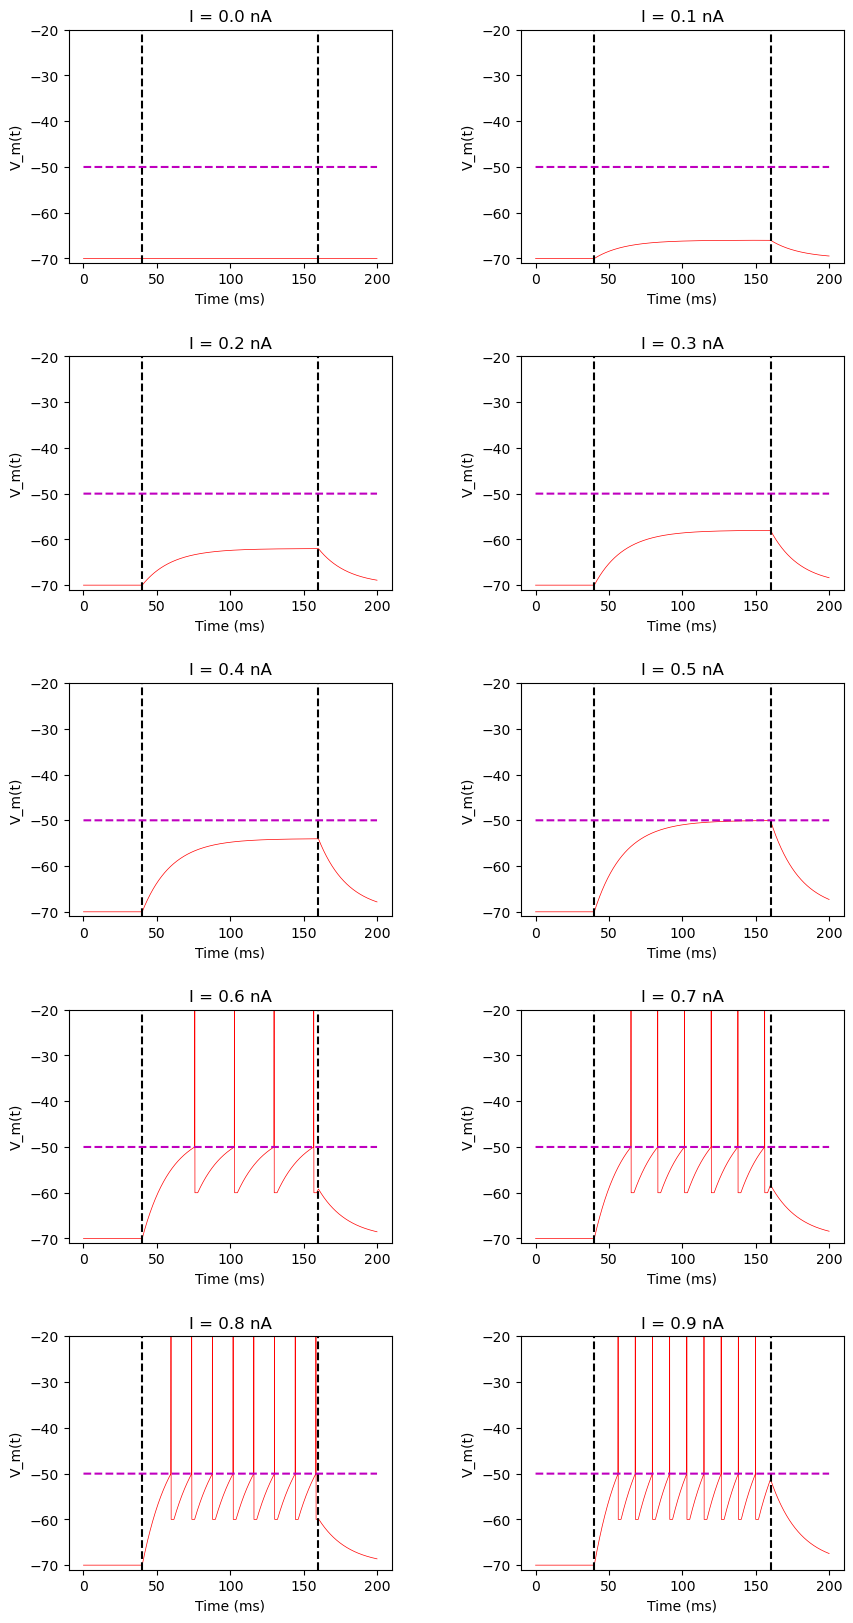

In [3]:
dt = 0.1 #ms
current = np.arange(0, 1, 0.1) #nA
max_time = 200 #ms
V_th = -50 #mV
time = np.arange(0, max_time, dt)
start_time_pos = int(0.2*len(time))
end_time_pos = int(0.8*len(time))

# Computing the LIF model with a range of current values and a single dt value
V_struct, ISI_struct, CV_struct, f_struct = leaky_integrate_and_fire(current, max_time, dt)

x_ = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
y_ = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
ylim_lb = -71
ylim_ub = -20
fig, axs = plt.subplots(5, 2, figsize = (10, 20))
plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
V_m = V_struct[str(dt)]
for blurb in range(len(current)):
    axs[x_[blurb], y_[blurb]].plot(time, V_m[blurb, :], 'r-',linewidth = 0.5)
    axs[x_[blurb], y_[blurb]].plot(time[start_time_pos]*np.ones((10, 1)), np.linspace(ylim_lb, ylim_ub, 10), 'k--')
    axs[x_[blurb], y_[blurb]].plot(time[end_time_pos]*np.ones((10, 1)), np.linspace(ylim_lb, ylim_ub, 10), 'k--')
    axs[x_[blurb], y_[blurb]].plot(time, V_th * np.ones((len(time), 1)), 'm--')
    axs[x_[blurb], y_[blurb]].set_ylim(ylim_lb, ylim_ub)
    axs[x_[blurb], y_[blurb]].set_ylabel('V_m(t)')
    axs[x_[blurb], y_[blurb]].set_xlabel('Time (ms)')
    axs[x_[blurb], y_[blurb]].set_title('I = '+str(round(current[blurb], 1))+ ' nA')

Q1. Using a fixed current value of I = 0.55 nA and by varying dt, we can see that the model characteristics do not change. What changes is the sampling resolution. We can see clear spikes for dt = 0.01 and 0.1 ms. For dt = 1 ms, the resolution is low enough to not resolve tau refractory. For dt = 5 ms, the resolution is too bad to not sample more than 1 spike.

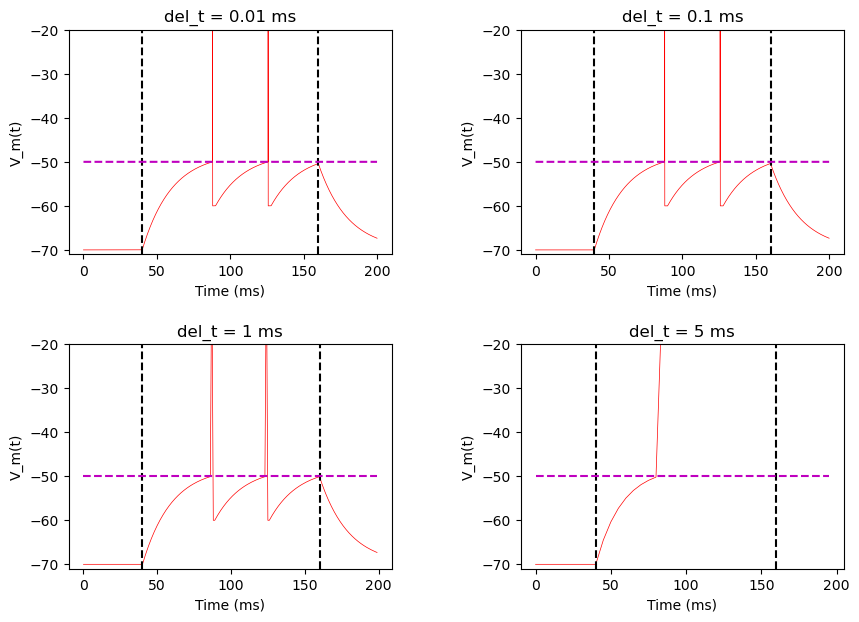

In [4]:
dt = [0.01, 0.1, 1, 5] #ms
current = 0.55 #nA
max_time = 200 #ms
V_th = -50 #mV

V_struct, ISI_struct, CV_struct, f_struct = leaky_integrate_and_fire(current, max_time, dt)

x_ = [0, 0, 1, 1]
y_ = [0, 1, 0, 1]
ylim_lb = -71
ylim_ub = -20
fig, axs = plt.subplots(2, 2, figsize = (10, 7))
plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
for blurb in range(len(dt)):
    time = np.arange(0, max_time, dt[blurb])
    start_time_pos = int(0.2*len(time))
    end_time_pos = int(0.8*len(time))
    V_m = V_struct[str(dt[blurb])]
    axs[x_[blurb], y_[blurb]].plot(time, V_m[0, :], 'r-',linewidth = 0.5)
    axs[x_[blurb], y_[blurb]].plot(time[start_time_pos]*np.ones((10, 1)), np.linspace(ylim_lb, ylim_ub, 10), 'k--')
    axs[x_[blurb], y_[blurb]].plot(time[end_time_pos]*np.ones((10, 1)), np.linspace(ylim_lb, ylim_ub, 10), 'k--')
    axs[x_[blurb], y_[blurb]].plot(time, V_th * np.ones((len(time), 1)), 'm--')
    axs[x_[blurb], y_[blurb]].set_ylim(ylim_lb, ylim_ub)
    axs[x_[blurb], y_[blurb]].set_ylabel('V_m(t)')
    axs[x_[blurb], y_[blurb]].set_xlabel('Time (ms)')
    axs[x_[blurb], y_[blurb]].set_title('del_t = '+str(round(dt[blurb], 2))+ ' ms')

Q2. The critical value of I ($I_c$) is given analytically by: \
$I_c = G_L * (V_{th} - V_L)$\
Also, the analytical f(I) function is:\
$f(I) = \frac{1}{\tau_{ref} + \frac{C}{G_L}ln[1+\frac{G_L * (V_{th} - V_L)}{(I - I_c)}]}$\
for $I > I_c$ and is infinity otherwise.\
Here, the theoretical f is multiplied by 60, to convert the units to per s or Hz.

In [5]:
def analytical_f(I):
    V_th = -50 #mV
    V_reset = -60 #mV
    tau_ref = 2 #ms
    C = 0.5 #nF
    G_L = 0.025 #uS
    V_L = -70 #mV
    V_spike = 0 #mV
    I_c = G_L * (V_th - V_L)
    f_theoretical = np.zeros((len(I), 1))
    for ii in range(len(I)):
        if I[ii] > I_c:
            f_theoretical[ii] = 60/(tau_ref + (C/G_L) * np.log(1+(G_L * (V_th - V_reset)/(I[ii] - I_c))))
    return f_theoretical

The empirical ISI is computed as the mean number of spikes present per second. The frequency is then given as 1/ISI.
The critical value of f above which the neuron starts spiking is given analytically using the formula:
$I_c = G_L \times (V_{th} - V_L)$\
And can also be determined empirically by checking the first non-zero value of f. Since f = 1/ISI, the zeros are in fact infinities.\
By both methods, we find $I_c = 0.5 nA $\
We can also see the analytical and empirical f-I plot do match pretty well.

The critical value Ic at above which the model fires spikes repetitively is 0.5 Hz.


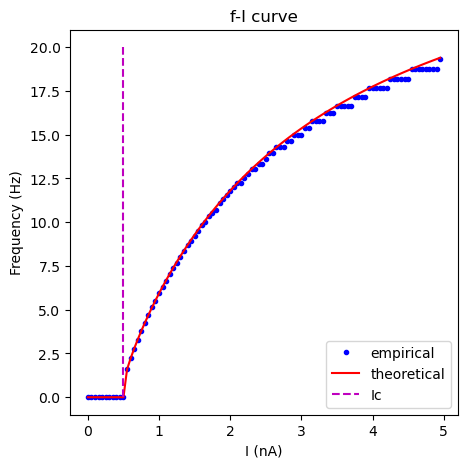

In [6]:
dt = 0.1 #ms
current = np.arange(0, 5, 0.05) #nA
max_time = 500 #ms
V_th = -50 #mV
time = np.arange(0, max_time, dt)
start_time_pos = int(0.2*len(time))
end_time_pos = int(0.8*len(time))

V_struct, ISI_struct, CV_struct, f_struct = leaky_integrate_and_fire(current, max_time, dt)

freqs_nonoise = f_struct[str(dt)]
last_zero_freq = np.argwhere(freqs_nonoise == 0)[-1, 0]

I_c = current[last_zero_freq]
print('The critical value Ic at above which the model fires spikes repetitively is ' + str(I_c) + ' Hz.')
max_freq_bound = int(np.ceil(np.nanmax(freqs_nonoise)))+1

f_theoretical = analytical_f(current)
fig = plt.figure(figsize = (5, 5))
plt.plot(current, freqs_nonoise, 'bo', markersize = 3, label = 'empirical')
plt.plot(current, f_theoretical, 'r-', markersize = 3, label = 'theoretical')
plt.plot(I_c * np.ones((max_freq_bound, 1)), np.arange(0, max_freq_bound), 'm--', label = 'Ic')
plt.xlabel('I (nA)')
plt.ylabel('Frequency (Hz)')
plt.title('f-I curve')
plt.legend()
plt.show()

Q3(a). Adding the noise term results in change of the form of the differential equation. Specifically, we have:\
C$\frac{dV_m}{dt} = -G_L(V_m-V_L) + I + \sigma w(t)$\
where, C is the membrane capacitance, $V_m$ is the membrane potential, t is time\
$G_L$ is the leak conductance, $V_L$ is leak reversal potential, I is the input current,\
$\sigma $ is the noise level, and w(t) is a sample from a standard normal distribution.\
Dividing both sides of the equation by C, we get:\
$\frac{dV_m}{dt} = \frac{-G_L(V_m-V_L) + I}{C} + \frac{\sigma}{C} w(t)$\
The equation can be implemented using Euler's method as: \
$\frac{\Delta V_m}{\Delta t} = \frac{-G_L(V_m-V_L) + I}{C}+ \frac{\sigma}{C} w(t)$\
$\therefore \Delta V_m = \Delta t \times \frac{-G_L(V_m-V_L) + I}{C}+ \frac{\sigma}{C} \sqrt{\Delta t} w(t)$\
Implementing this equation, we can see that the noisy term does induce fluctuations in the baseline Vm(t). This can result in spikes at sub-threshold levels of current. Additionally, because of this noise-term, the spikes become more random and tend to have different intervals.\
We can also see that the randomness of spikes becomes less evident at higher currents as the spikes become more frequent.

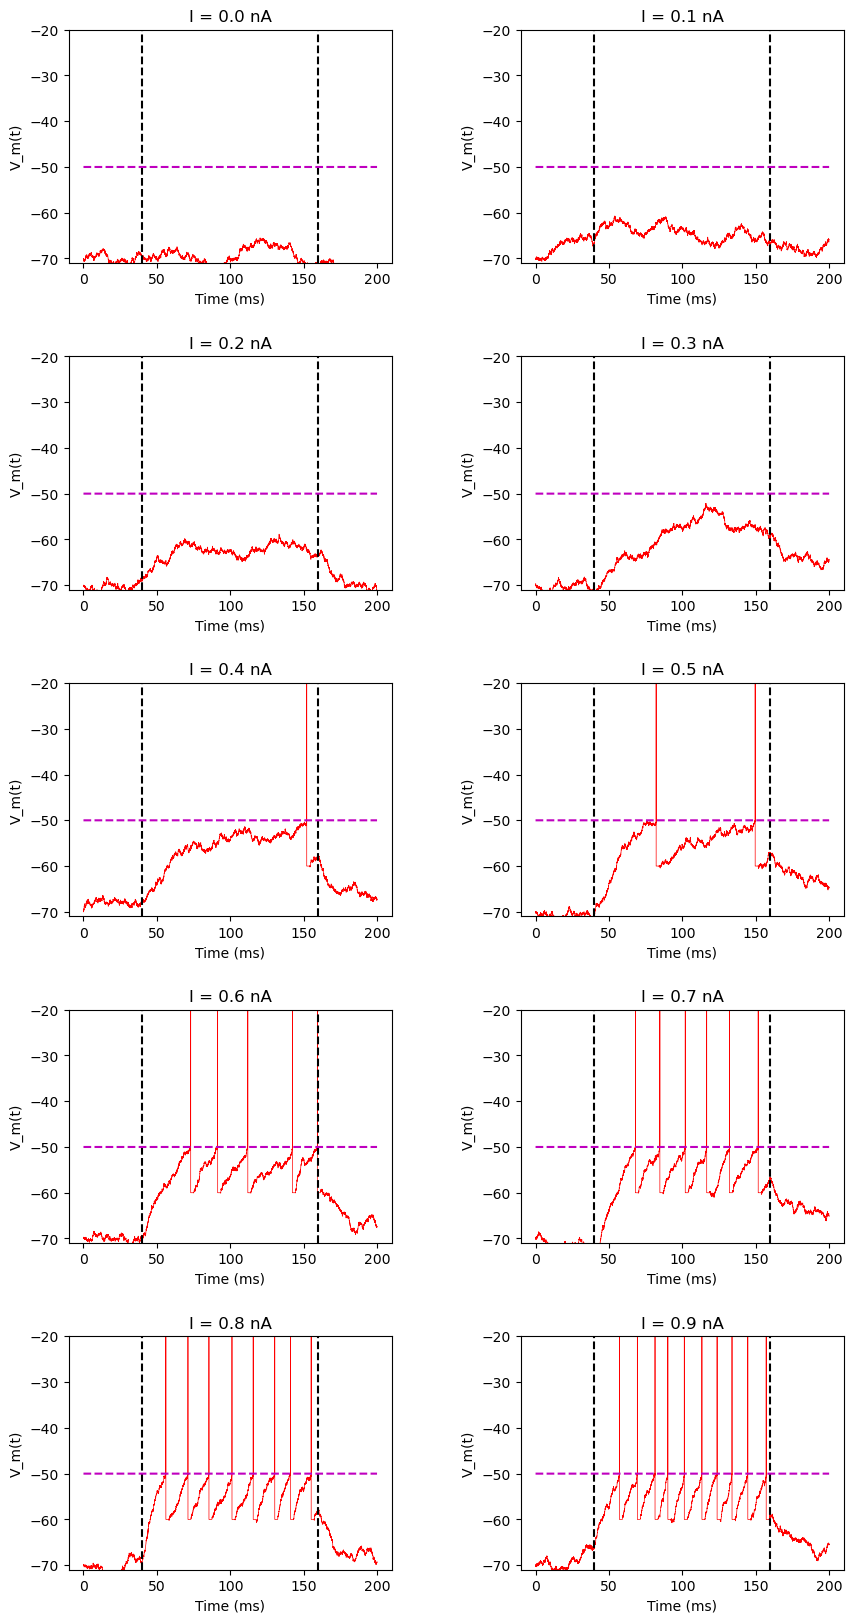

In [7]:
dt = 0.01 #ms
current = np.arange(0, 1, 0.1) #nA
max_time = 200 #ms
V_th = -50 #mV
time = np.arange(0, max_time, dt)
start_time_pos = int(0.2*len(time))
end_time_pos = int(0.8*len(time))

V_struct, ISI_struct, CV_struct, f_struct = leaky_integrate_and_fire(current, max_time, dt, model = 'noisy')

x_ = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
y_ = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
ylim_lb = -71
ylim_ub = -20
fig, axs = plt.subplots(5, 2, figsize = (10, 20))
plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
V_m = V_struct[str(dt)]
for blurb in range(len(current)):
    axs[x_[blurb], y_[blurb]].plot(time, V_m[blurb, :], 'r-',linewidth = 0.5)
    axs[x_[blurb], y_[blurb]].plot(time[start_time_pos]*np.ones((10, 1)), np.linspace(ylim_lb, ylim_ub, 10), 'k--')
    axs[x_[blurb], y_[blurb]].plot(time[end_time_pos]*np.ones((10, 1)), np.linspace(ylim_lb, ylim_ub, 10), 'k--')
    axs[x_[blurb], y_[blurb]].plot(time, V_th * np.ones((len(time), 1)), 'm--')
    axs[x_[blurb], y_[blurb]].set_ylim(ylim_lb, ylim_ub)
    axs[x_[blurb], y_[blurb]].set_ylabel('V_m(t)')
    axs[x_[blurb], y_[blurb]].set_xlabel('Time (ms)')
    axs[x_[blurb], y_[blurb]].set_title('I = '+str(round(current[blurb], 1))+ ' nA')

Q3(b). The mean firing rate is computed as the average of the ISI. Plotting f-I plots for the no-noise and with noise conditions, we can see that the plots align pretty well for high currents ($I > I_c$). For $I < I_c$, the no-noise curve jumps to 0 and hence has an infinite slope, while the one with the noise condition, slowly decays down.

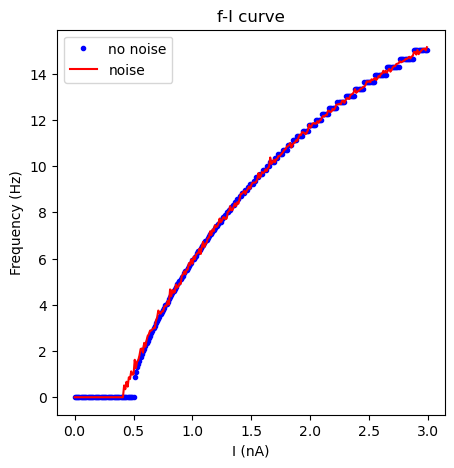

In [8]:
dt = 0.1 #ms
current = np.arange(0, 3, 0.01) #nA
max_time = 1000 #ms

# LIF model without noise
V_struct, ISI_struct, CV_struct, f_struct = leaky_integrate_and_fire(current, max_time, dt)
freqs_nonoise = f_struct[str(dt)]

# LIF model with noise
V_struct, ISI_struct, CV_struct, f_struct = leaky_integrate_and_fire(current, max_time, dt, model = 'noisy')
freqs_noise = f_struct[str(dt)]

f_theoretical = analytical_f(current)
fig = plt.figure(figsize = (5, 5))
plt.plot(current, freqs_nonoise, 'bo', markersize = 3, label = 'no noise')
plt.plot(current, freqs_noise, 'r-', markersize = 3, label = 'noise')
plt.xlabel('I (nA)')
plt.ylabel('Frequency (Hz)')
plt.title('f-I curve')
plt.legend()
plt.show()

Q3(c). The coefficient of variation (CV) is the ratio of the standard deviation of ISI and the mean of ISI and is given by:\
$CV = \frac{<(ISI - <ISI>)^2>^{1/2}}{<ISI>}$\
We can see that as the firing rate increases, CV decreases monotonically. This is because with an increase in the firing rate, the variation is the number of spikes decreases i.e. the standard deviations of ISI decreases for higher firing rates resulting in low CV.

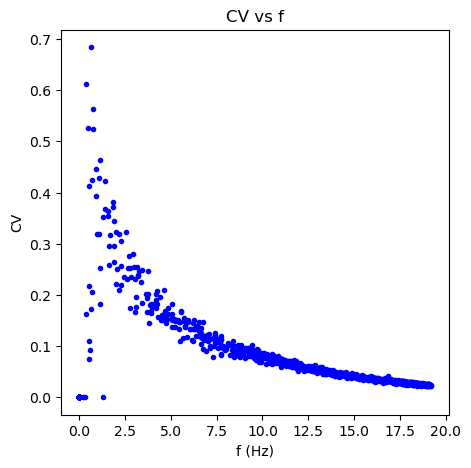

In [9]:
dt = 0.1 #ms
current = np.arange(0, 5, 0.005) #nA
max_time = 1000 #ms

V_struct, ISI_struct, CV_struct, f_struct = leaky_integrate_and_fire(current, max_time, dt, model = 'noisy')
freqs = f_struct[str(dt)]
CV = CV_struct[str(dt)]

fig = plt.figure(figsize = (5, 5))
plt.plot(freqs, CV, 'bo', markersize = 3)
plt.xlabel('f (Hz)')
plt.ylabel('CV')
plt.title('CV vs f')
plt.show()